# Analysis \#5: Completing the Toy Analysis on Averaged Waveform Data

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
#vimport oss
import ROOT
from IPython.display import clear_output, display

from helper import *


Welcome to JupyROOT 6.24/00


In [2]:
#df_heightcut_accumulate.to_pickle('s011_f00001_ts1520181395-2000_15500_maxheightcut.pkl')
df_heightcut_accumulate = pd.read_pickle('raw/s011_f00001_ts1520181395-2000_15500_maxheightcut.pkl')


df_heightcut_accumulate = df_heightcut_accumulate[df_heightcut_accumulate.maxheight < 15000]

#df_heightcut_accumulate = df_heightcut_accumulate[df_heightcut_accumulate.maxheight < 10000]
df_heightcut_accumulate = df_heightcut_accumulate[df_heightcut_accumulate.maxheight > 5000]

In [3]:
df_heightcut_accumulate

,event_number,det_number,arrival_time,area,psd,pulse,pid,simtruth_E,simtruth_Z,maxheight
8540,41,27,8.237818e+07,49424.445312,0.143136,"[3, 1, 0, 1, 13, 18, 148, 1321, 4128, 6630, 66...",0,0.0,0.0,6664
22971,112,85,2.218948e+08,46591.554688,0.117947,"[4, 1, 1, -2, 0, 1, 222, 2206, 5955, 7712, 740...",0,0.0,0.0,7712
41778,203,49,4.007110e+08,91582.250000,0.150037,"[0, 0, 1, -4, -2, 3, 92, 1833, 6870, 10949, 11...",0,0.0,0.0,11667
143074,687,45,1.351780e+09,43098.777344,0.145607,"[2, -2, 1, -2, 1, -1, 68, 1168, 4813, 6451, 58...",0,0.0,0.0,6451
156436,752,67,1.479506e+09,108.333336,0.997505,"[-3, 0, 1, 1, -2, 1, 0, 3, 30, 48, 34, 11, 3, ...",0,0.0,0.0,8479
...,...,...,...,...,...,...,...,...,...,...
5778693,151559,148,2.978264e+11,81623.218750,0.118875,"[0, 1, -2, -2, -1, 1, 49, 1794, 11030, 14743, ...",0,0.0,0.0,14743
5778694,151559,146,2.978264e+11,49666.890625,0.124511,"[1, -2, -1, -6, 4, 13, 302, 4760, 9780, 8454, ...",0,0.0,0.0,9780
5815199,151742,291,2.981860e+11,29961.333984,0.104696,"[1, 3, -1, 2, -1, 12, 254, 1742, 4135, 5025, 4...",0,0.0,0.0,5025
5816141,151747,52,2.981958e+11,103.666664,0.997312,"[-4, 0, 0, -1, 1, 2, -1, 6, 45, 36, 9, 2, 0, 1...",0,0.0,0.0,6332


### Constructing a high-energy template waveform

In [4]:
df_heightcut_accumulate_normalized = df_heightcut_accumulate.copy()

# normalize ish so waveforms are on the same scale
df_heightcut_accumulate_normalized['pulse']=df_heightcut_accumulate_normalized['pulse'].multiply(15000/df_heightcut_accumulate_normalized['maxheight'], axis="index")

# get rid of secondary peak events
ctr = 0
for index, row in df_heightcut_accumulate_normalized.iterrows():
    
    if np.amax(row[5][25:len(row[5])]) > 3000: 
        
        ctr = ctr+1
        
        df_heightcut_accumulate_normalized.drop([index], inplace=True)
        #df_heightcut_accumulate_normalized.at[index,'pulse'] = np.zeros(len(row[5]))
        
        print('index dropped: '+str(index))
        #print(str(row[5][25:len(row[5])]))
        
print('total removed: '+str(ctr))
   
# normalize again    
df_heightcut_accumulate_normalized['maxheight'] = list(np.amax(j) for j in df_heightcut_accumulate_normalized['pulse'])
#df_heightcut_accumulate_normalized['pulse']=df_heightcut_accumulate_normalized['pulse'].multiply(15000/df_heightcut_accumulate_normalized['maxheight'], axis="index")  
df_heightcut_accumulate_normalized['pulse']=df_heightcut_accumulate_normalized['pulse'].multiply(df_heightcut_accumulate_normalized['maxheight']/15000, axis="index") 


index dropped: 156436
index dropped: 814793
index dropped: 997172
index dropped: 1878161
index dropped: 2914053
index dropped: 3578125
index dropped: 3578131
index dropped: 3578372
index dropped: 4513623
index dropped: 4513668
index dropped: 4652608
index dropped: 4913459
index dropped: 272621
index dropped: 543210
index dropped: 906718
index dropped: 1088963
index dropped: 2065030
index dropped: 2458992
index dropped: 2593813
index dropped: 2687342
index dropped: 2887068
index dropped: 3990580
index dropped: 3998057
index dropped: 4653171
index dropped: 4956213
index dropped: 227964
index dropped: 1167756
index dropped: 2724476
index dropped: 79499
index dropped: 79599
index dropped: 456060
index dropped: 819227
index dropped: 1986709
index dropped: 2234840
index dropped: 2882122
index dropped: 2993475
index dropped: 2993491
index dropped: 3051464
index dropped: 4863959
index dropped: 260216
index dropped: 632570
index dropped: 684874
index dropped: 1128114
index dropped: 2723925
inde

In [5]:
wow = sum(list(np.asarray(df_heightcut_accumulate_normalized['pulse'])))
wow = wow/len(list(np.asarray(df_heightcut_accumulate_normalized['pulse'])))

In [6]:
# get stddev
st = np.asarray(df_heightcut_accumulate_normalized['pulse'])
st = np.stack(st)
stdev = np.std(st, axis=0)

<ipython-input-7-ddce27b9c527>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(xtemplate, ytemplate, 'k-', color='blue', marker='.')


Text(0.5, 1.0, 'data-average template waveform, 1 stdev band')

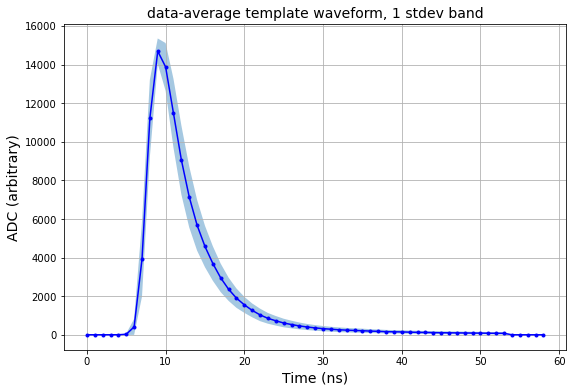

In [7]:
xtemplate = np.arange(len(wow)) # *4 to convert to ns
ytemplate = wow

plt.rcParams["figure.figsize"] = (9,6)
plt.plot(xtemplate, ytemplate, 'k-', color='blue', marker='.')
#plt.plot(np.arange(len(wow))*4, wow, color='red', linestyle='', marker='.')
plt.fill_between(xtemplate, ytemplate+stdev, ytemplate-stdev, alpha=0.4)
#plt.fill_between(np.arange(len(wow))*4, wow+2*stdev, wow-2*stdev, alpha=0.3, color='blue')
plt.grid()
plt.xlabel('Time (ns)',fontsize=14); plt.ylabel('ADC (arbitrary)',fontsize=14)
plt.title('data-average template waveform, 1 stdev band', fontsize=14)


In [8]:
psd = get_PSD_discretepts(xtemplate, ytemplate)
psd_high = get_PSD_discretepts(xtemplate, ytemplate+stdev)
psd_low = get_PSD_discretepts(xtemplate, ytemplate-stdev)

area = get_total_area_discretepts(xtemplate, ytemplate)
area_high = get_total_area_discretepts(xtemplate, ytemplate+stdev)
area_low = get_total_area_discretepts(xtemplate, ytemplate-stdev)

In [9]:
print('PSD: '+str(psd)+' [' + str(psd_low) + ', ' + str(psd_high) + ']')
print('area: '+str(area)+' [' + str(area_low) + ', ' + str(area_high) + ']')

PSD: 0.13923222551482312 [0.1094125265080325, 0.15900078060684034]
area: 101487.21743990187 [82215.2750680501, 120759.15981175362]


In [10]:
# idea #1: treat the original, original+/- stdev waveforms as 3 separate ones, and perform the toy analysis on it
# come up with a uncertainty band for the PSD and energy calculation 
# idea #2: for each datapoint, get an uncertainty on the area (easy) and the PSD (maxtail/mintotal) to (mintail/maxtotal)

### Perform a Toy Analysis assuming an arbitrary clipping height

In [11]:
#xtemplate, ytemplate+stdev

high_bound = ytemplate+stdev
low_bound = ytemplate-stdev

clip_height = 16000
#scale_factor = np.random.rand(10000)*20 
scale_factor = np.linspace(0.1, 2000, 20000)

In [12]:
area_list = np.asarray([])
area_high_list = np.asarray([]) 
area_low_list = np.asarray([])

psd_list = np.asarray([])
psd_high_list = np.asarray([])
psd_low_list = np.asarray([])

time_list = np.asarray([])

it = 0

#scale_factor = [10]

for sf in scale_factor: 
    
    it = it+1
    
    clear_output(wait=True)
    print(str(it)+ ' out of '+str(len(scale_factor)))
    
    scaled_ytemplate = ytemplate*sf
    scaled_high_bound = high_bound*sf
    scaled_low_bound = low_bound*sf
    
    scaled_ytemplate[scaled_ytemplate > clip_height] = clip_height
    scaled_high_bound[scaled_high_bound > clip_height] = clip_height
    scaled_low_bound[scaled_low_bound > clip_height] = clip_height
    
    area = get_total_area_discretepts(xtemplate, scaled_ytemplate)
    area_high = get_total_area_discretepts(xtemplate, scaled_high_bound)
    area_low = get_total_area_discretepts(xtemplate, scaled_low_bound)
    
    area_list = np.append(area_list, area)
    area_high_list = np.append(area_high_list, area_high)
    area_low_list = np.append(area_low_list, area_low)
    
    psd = get_PSD_discretepts(xtemplate, scaled_ytemplate)
    psd_high = get_PSD_discretepts(xtemplate, scaled_high_bound)
    psd_low = get_PSD_discretepts(xtemplate, scaled_low_bound)
    
    psd_list = np.append(psd_list, psd)
    psd_high_list = np.append(psd_high_list, psd_high)
    psd_low_list = np.append(psd_low_list, psd_low)
    
    time_list = np.append(time_list, get_time_index(xtemplate, scaled_ytemplate))
    
    # for debugging
#     plt.plot(xtemplate, scaled_ytemplate, marker='.')
#     print(get_time_index(xtemplate, scaled_ytemplate) )

20000 out of 20000


Text(0, 0.5, 'arrival time (ns)')

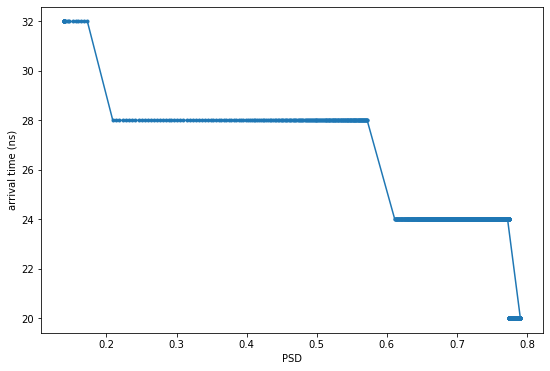

In [13]:
plt.plot(psd_list, time_list*4, linestyle='-', marker='.')
plt.xlabel('PSD')
plt.ylabel('arrival time (ns)')

Text(0, 0.5, 'psd')

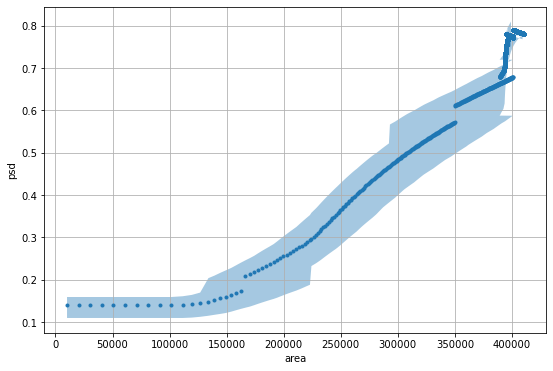

In [14]:
plt.plot(area_list, psd_list, linestyle='', marker='.')
plt.fill_between(area_list, psd_high_list, psd_low_list, alpha=0.4)
plt.grid()
plt.xlabel('area')
plt.ylabel('psd')

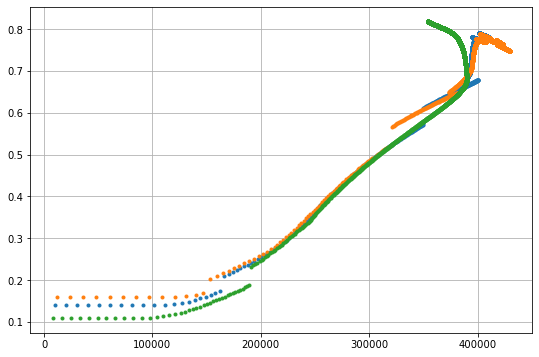

In [15]:
plt.plot(area_list, psd_list, linestyle='', marker='.')
plt.plot(area_high_list, psd_high_list, linestyle='', marker='.')
plt.plot(area_low_list, psd_low_list, linestyle='', marker='.')
plt.grid()

### Test the PSD-time offset mapping, test this on a template waveform

In [16]:
offset_indices1 = np.where(time_list==8)
offset_indices2 = np.where(time_list==7)
offset_indices3 = np.where(time_list==6)
offset_indices4 = np.where(time_list==5)

In [17]:
psd_tier1 = psd_list[offset_indices1]
psd_tier2 = psd_list[offset_indices2]
psd_tier3 = psd_list[offset_indices3]
psd_tier4 = psd_list[offset_indices4]

In [18]:
offsets_ns = np.zeros(len(psd_list))
offsets_ns[offset_indices1] = 0
offsets_ns[offset_indices2] = 4
offsets_ns[offset_indices3] = 8
offsets_ns[offset_indices4] = 12

In [19]:
dict_psd2offset = dict(zip(psd_list, offsets_ns))

### Compare to the Template Waveform

In [20]:
templatefile = ROOT.TFile.Open('templates/AD_Templates.root',"READ")
graph_early = templatefile.Get("gPSD_Template_3_0")

temp_x, temp_y = get_xy_from_TGraph(graph_early)

In [21]:
xshift = 30
xscale = 1
yscale = np.amax(temp_y)/np.amax(wow) 

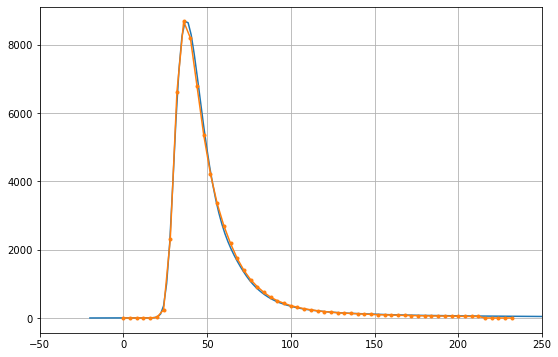

In [22]:
xparam_plt = np.arange(len(wow))*4
xparam = np.arange(len(wow))*4
yparam = wow*yscale

plt.plot(temp_x+30, temp_y)
plt.plot(xparam_plt, yparam, marker='.')

plt.xlim(-50, 250)
plt.grid()

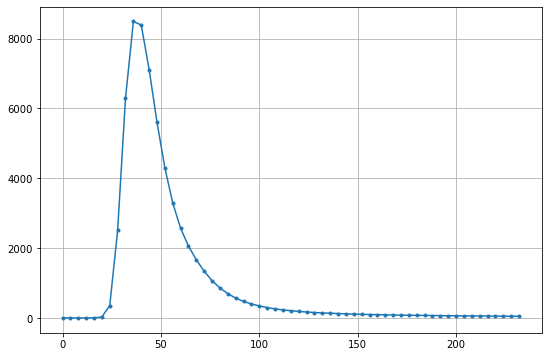

In [23]:
temp_y_sample_points = np.interp(xparam, temp_x+30, temp_y)
plt.plot(xparam, temp_y_sample_points, marker='.')
plt.grid()

In [31]:
clip_heights = np.linspace(100, np.amax(temp_y_sample_points), 10000)

psd_list = np.asarray([]); atime_list = np.asarray([])

for ch in clip_heights: 
    
    temp_y_sample_points_clipped = np.copy(temp_y_sample_points)
    temp_y_sample_points_clipped[temp_y_sample_points_clipped > ch] = ch
    
    psd = get_PSD_discretepts(xparam, temp_y_sample_points_clipped)
    psd_list = np.append(psd_list, psd)
    
    atime = get_time_index(xparam, temp_y_sample_points_clipped)
    atime_list = np.append(atime_list, atime)

Text(0.5, 0, 'PSD')

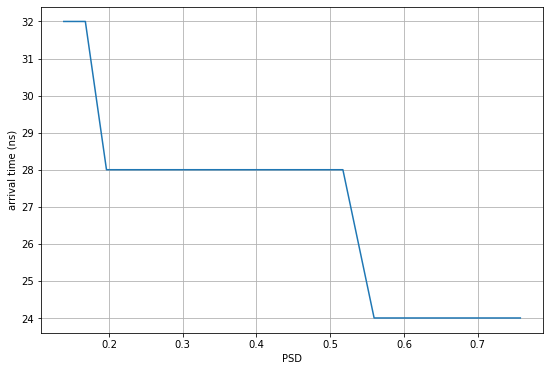

In [33]:
plt.plot(psd_list, atime_list*4)
plt.grid()
plt.ylabel('arrival time (ns)')
plt.xlabel('PSD')

In [26]:
atime_list_uncorrected = np.copy(atime_list)

for i in range(len(psd_list)): 
    if psd_list[i] > np.amax(psd_tier1): 
        atime_list[i] = atime_list[i] + 1
    if psd_list[i] > np.amax(psd_tier2): 
        atime_list[i] = atime_list[i] + 1
    if psd_list[i] > np.amax(psd_tier3): 
        atime_list[i] = atime_list[i] + 1
    if psd_list[i] > np.amax(psd_tier4): 
        atime_list[i] = atime_list[i] + 1
        

Text(0, 0.5, 'Arrival time (ns)')

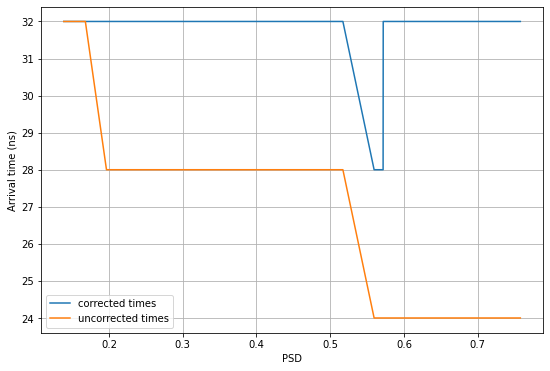

In [27]:
plt.plot(psd_list, atime_list*4, label='corrected times')
plt.plot(psd_list, atime_list_uncorrected*4, label='uncorrected times')
plt.grid()
plt.legend()
plt.xlabel('PSD'); plt.ylabel('Arrival time (ns)')

### Quick Visualization of Individual Events

In [28]:
largelist = list(df_heightcut_accumulate.event_number)
largelist = set(largelist)
largelist = np.sort(list(largelist))

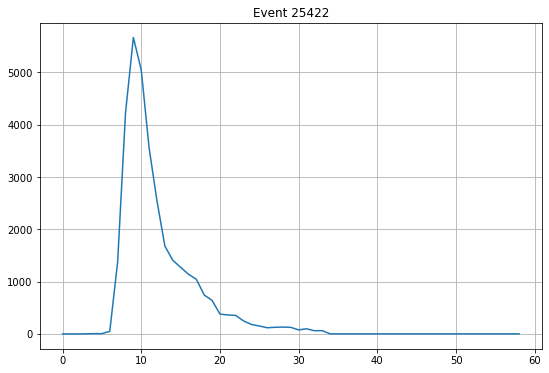

In [29]:
index = 104

en = largelist[index]

df_oneevent = df_heightcut_accumulate[df_heightcut_accumulate.event_number == en]

for index, row in df_oneevent.iterrows():
    if np.amax(row[5]): 
        plt.plot(row[5])

plt.title('Event '+str(en))
plt.grid()